In [1]:
import cv2
import os
from os import listdir
import numpy as np
from matplotlib import pyplot as plt

norm  = np.linalg.norm
cross = np.cross
arr   = np.array

In [16]:
def cast(a):    
    '''
    Gets output of cv2.findChessboardCorners
    Returns an array of corners of necessary shape
    '''
    
    b = np.zeros([len(a), 2])
    for i in range(len(b)):
        b[i] = a[i][0]
    return b

def corners_sort(cast_cors, shape=(7,7)):
    '''
    Gets casted output of cv2.findChessboardCorners
    Returns sorted edge corners of the desk
    2 3
    1 4
    '''
    board_size = shape[0]
    
    cors = np.zeros((4, 2))

    cors[0] = cast_cors[ 0]             #geting edge corners
    cors[1] = cast_cors[ board_size-1]
    cors[2] = cast_cors[-board_size]
    cors[3] = cast_cors[-1]

    sort12 = arr(sorted(sorted(cors,  key = lambda x: x[0])[:2], key = lambda x: x[1])) 
    sort34 = arr(sorted(sorted(cors,  key = lambda x: x[0])[2:], key = lambda x: x[1]))

    sort = np.zeros((4, 2))

    sort[0] = sort34[0]         #sorting by pattern
    sort[1] = sort12[0]
    sort[2] = sort12[1] 
    sort[3] = sort34[1]
    
    return sort
    
def pix_trans(pixels, photo_shape):
    '''
    Gets coordinates in the image in left top corner reference system
    Returns coordinates of projection of light rays on photomatrix in central reference system
    '''

    const = 1/2 * (photo_shape[:-1][::-1] * arr([1, -1])) * np.ones(pixels.shape)

    coef  = arr([-1, 1]) * np.ones(pixels.shape) 

    #invert (*-1) because lens invert image
    return - (coef * pixels + const) 

def point_trans(points, photo_shape):
    
    if len (points) == 3:
        M = arr ([[1, 0, 0], [0, 0, 1]])
        points1 = M.dot(points)
    else:
        points1 = copy (points)

    const = 1/2 * (photo_shape[:-1][::-1] * arr([1, 1])) * np.ones(points1.shape)

    coef  = arr([1, -1]) * np.ones(points1.shape) 

    return  (coef * points1 + const)

def calc (points):
    p1 = arr ([points[0][0], 0, points[0][1]])
    p2 = arr ([points[1][0], 0, points[1][1]])
    p3 = arr ([points[2][0], 0, points[2][1]])
    p4 = arr ([points[3][0], 0, points[3][1]])
    
    d = np.cross ( p1 - p2, p3 - p4 )[1]
    A =     arr ([-p1 + p2, p3 - p4]).T
    b = arr ([np.cross (p3, p4)[1], np.cross (p1, p2)[1]])

    D = A.dot(b)
    
    return d, D

def inter (points):
    
    set1 = points
    set2 = np.roll (points, 2)
    
    d1, D1 = calc (set1)
    d2, D2 = calc (set2)
    
    i1 = 1/d1 * D1
    i2 = 1/d2 * D2
    
    f = np.sqrt (- np.inner(i1, i2))
    
    i1 += f * arr ([0, 1, 0])
    i2 += f * arr ([0, 1, 0])
    
    return i1, i2, f
    
def basis (points):
    i1, i2, f = inter (points)
    
    
    x = i1 / norm (i1) * np.sign (i1[0])
    y = i2 / norm (i2) * np.sign (i2[1])
    z  = np.cross (x, y)
  
    return x, y, z


def centre (points, size):
    i1, i2, f = inter (points)
    
    M = arr ([[1, 0, 0], [0, 0, 1]])
    P = points.dot (M) + f * arr ([0, 1, 0])

    A = arr ([[      0,  P[0, 2], -P[0, 1]], 
             [-P[1, 2],        0,  P[1, 0]],
             [ P[2, 1], -P[2, 0],       0]])
    
    if np.linalg.det(A) == 0:
        return None

    x, y, z = basis (points)
    
    d = size * arr ([x + y, -x + y, -x - y, x - y])

    b = arr ([cross (P[0], d[0])[0], 
              cross (P[1], d[1])[1], 
              cross (P[2], d[2])[2]])
    
    
    C = np.linalg.solve (A, b)
    return C

def proj (Point, f):
    return Point * f / Point[1]

def find_knots (img, shape):
    _, knots = cv2.findChessboardCorners (img, shape)
    
    if _ == False:
        return None
    else:
        return cast (knots)

def plot_basis (img, shape, size, l=10, width=3):
    
    img = np.copy (img)
    
    plt.figure (figsize = (200, 10))
    
    knots = find_knots (img, shape)
    
    if type(knots) == type(None):
        return img, None, None
    else:
        corners = corners_sort (knots)
        points  = pix_trans (corners, img.shape)    


        i1, i2, f = inter (points)
        x, y, z = basis (points)
        B = arr ([x, y, z]).T
        BB = np.linalg.inv(B)
        
        C = centre (points, size=size) 

        if type (C) != type (None):
            #plt.plot (corners.T[0], corners.T[1], marker='o', color='springgreen', linestyle='', ms=5)
            #plt.imshow (img)


            o  = arr (img.shape[-2::-1]) / 2

            O = tuple (point_trans (proj (C,         f), img.shape).astype (int))
            X = tuple (point_trans (proj (C + l * x, f), img.shape).astype (int))
            Y = tuple (point_trans (proj (C + l * y, f), img.shape).astype (int))
            Z = tuple (point_trans (proj (C + l * z, f), img.shape).astype (int))


            vector_x = arr ([O, X])
            vector_y = arr ([O, Y])
            vector_z = arr ([O, Z])
            '''
            plt.plot (O[0], O[1], 'o', color='tab:red')
            plt.plot (X[0], X[1], 'o', color='red')
            plt.plot (Y[0], Y[1], 'o', color='green')
            plt.plot (Z[0], Z[1], 'o', color='blue')

            plt.plot (vector_x[0], vector_x[1], color='red',   linewidth=width)
            plt.plot (vector_y[0], vector_y[1], color='green', linewidth=width)
            plt.plot (vector_z[0], vector_z[1], color='blue',  linewidth=width)
            '''
            i = 230
            t = 2
            cv2.line (img, O, X, color = (i, 0, 0), thickness=t)
            cv2.line (img, O, Y, color = (0, i, 0), thickness=t)
            cv2.line (img, O, Z, color = (0, 0, i), thickness=t)

            cv2.circle(img, X, 5, (i, 0, 0), thickness=2*t)
            cv2.circle(img, Y, 5, (0, i, 0), thickness=2*t)
            cv2.circle(img, Z, 5, (0, 0, i), thickness=2*t)

            return img, C, -BB.dot(C)
        return img, None, None

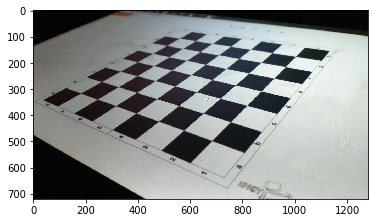

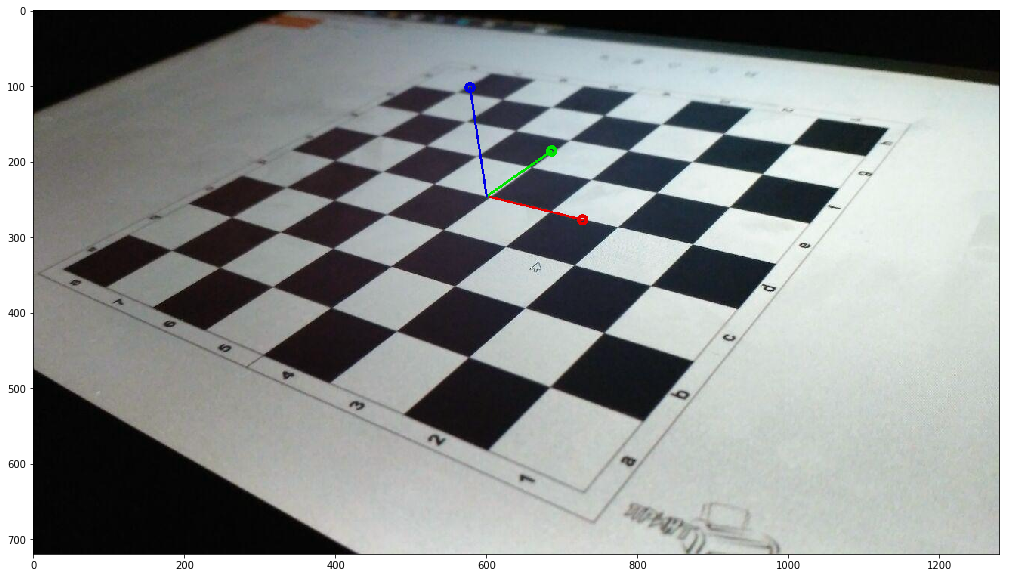

In [18]:
path = r'C:\nao_cv\geometrical\another_boards\\'
os.chdir(path)

name = 'photo_2019-10-09_05-57-14.jpg'


size  = 19
shape = (7, 7)

img  = cv2.imread (name)
plt.imshow (img)
img1, C, CC = plot_basis (img, shape, size)

plt.imshow (img1)